# KAfka WIndow Consumer from the Apache-Kafka namespace

In [ ]:
from kafka import KafkaConsumer

consumer = KafkaConsumer(
    "node-windows",
    bootstrap_servers=["kafka.apache-kafka.svc.cluster.local:9092"],
    auto_offset_reset="latest",
    enable_auto_commit=True,
    group_id="sunrise-cpu-lstm",
    value_deserializer=lambda v: v.decode("utf-8")
)

print("Listening...")

for msg in consumer:
    print(msg)


# Clean version to get only the desired sliding windows from a especific node  (node-0)

the topic gives windowds for all the nodes 
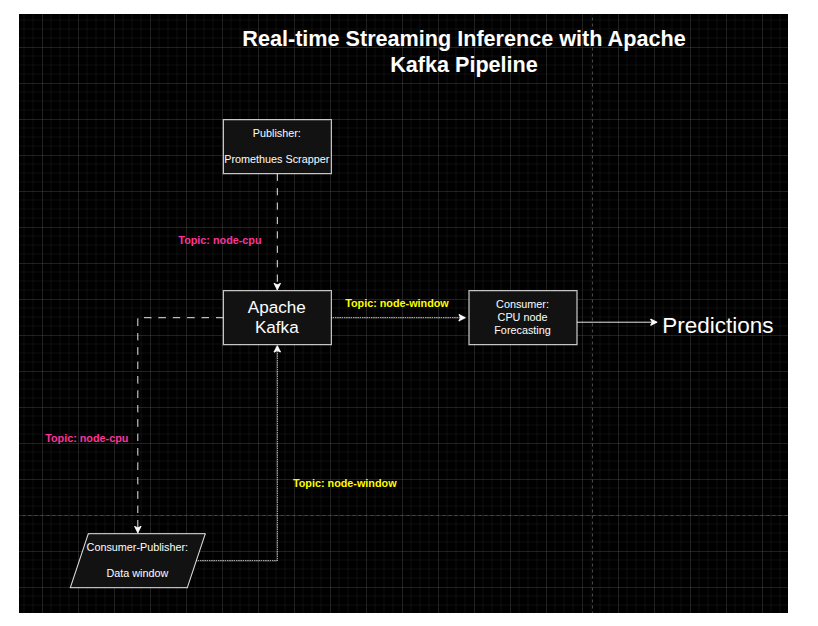

In [ ]:
from kafka import KafkaConsumer
import json

TARGET_NODE = "k3d-sunrise-agent-0:9100"
last_seen_ts = None

consumer = KafkaConsumer(
    "node-windows",
    bootstrap_servers=["kafka.apache-kafka.svc.cluster.local:9092"],
    group_id="model-inference-group",
    auto_offset_reset="earliest",
    enable_auto_commit=False,
    value_deserializer=lambda v: json.loads(v.decode("utf-8"))
)

print(f"Listening for ordered NEW windows from node={TARGET_NODE}")

for msg in consumer:
    data = msg.value
    node = data.get("node")

    # Debug: print all node names coming in
    print(f"DEBUG: got message from node={node}")

    if node != TARGET_NODE:
        continue

    window = data.get("window", [])
    if not window:
        continue

    current_last_ts = window[-1]["timestamp"]

    if current_last_ts == last_seen_ts:
        print(f"DEBUG: skipping duplicate window ending at {current_last_ts}")
        continue

    last_seen_ts = current_last_ts

    print(f"\n🔹 Node: {node}")
    print("Window:")
    for entry in window:
        print(f"   {entry['timestamp']} | CPU: {entry['cpu_percent']}%")


Listening for ordered NEW windows from node=k3d-sunrise-agent-0:9100
DEBUG: got message from node=k3d-sunrise-agent-0:9100

🔹 Node: k3d-sunrise-agent-0:9100
Window:
   2025-09-17 10:05:39 | CPU: 26%
   2025-09-17 10:06:40 | CPU: 27%
   2025-09-17 10:07:40 | CPU: 27%
   2025-09-17 10:08:40 | CPU: 27%
   2025-09-17 10:09:40 | CPU: 27%
DEBUG: got message from node=k3d-sunrise-server-0:9100
DEBUG: got message from node=k3d-sunrise-agent-2:9100


# CAlling the inferece model servr by Kserve inside the cluster

In [ ]:
import requests

# --- Pick ONE URL ---

# In-cluster (recommended): private revision service
URL = ("http://inference-serving-kserve-cpu-predictor-00001-private.lstm-iqu.svc.cluster.local"
       "/v2/models/inference-serving-kserve-cpu/infer")

# If you're port-forwarding the pod to localhost:8080, use this instead:
# URL = "http://localhost:8080/v2/models/inference-serving-kserve-cpu/infer"

# Dummy input window (matches your MLflow example and required shape [1,5,1])
window = [0.99565217196941376, 0.92826087474822998, 0.95, 0.90652173459529877, 0.22826087474822998]

payload = {
    "inputs": [{
        "name": "input-0",
        "shape": [1, 5, 1],
        "datatype": "FP32",
        "data": [[[float(x)] for x in window]]  # -> [1,5,1]
    }]
}

resp = requests.post(URL, json=payload, timeout=10)
print("Status:", resp.status_code)
print("Body:", resp.text)


# Joinig the KAfka and the calling inference

In [ ]:

from kafka import KafkaConsumer
import requests
import json

# === CONFIG ===
TARGET_NODE = "k3d-sunrise-agent-0:9100"
KAFKA_TOPIC = "node-windows"
KAFKA_BROKER = "kafka.apache-kafka.svc.cluster.local:9092"

# KServe V2 inference endpoint (in-cluster)
KSERVE_URL = (
    "http://inference-serving-kserve-cpu-predictor-00001-private.lstm-iqu.svc.cluster.local"
    "/v2/models/inference-serving-kserve-cpu/infer"
)

# === HELPERS ===
def normalize(cpu_percent):
    """Normalize CPU % to float32 in [0.0, 1.0]"""
    return float(cpu_percent) / 100.0

def make_payload(cpu_window):
    """Takes a list of 5 floats → returns KServe V2 payload with shape [1,5,1]"""
    shaped = [[[x]] for x in cpu_window]       # shape [5,1]
    return {
        "inputs": [{
            "name": "input-0",
            "shape": [1, 5, 1],
            "datatype": "FP32",
            "data": [shaped]                    # wrapped to [1,5,1]
        }]
    }

# === SETUP ===
consumer = KafkaConsumer(
    KAFKA_TOPIC,
    bootstrap_servers=[KAFKA_BROKER],
    group_id="kserve-cpu-inference",
    auto_offset_reset="latest",
    enable_auto_commit=True,
    value_deserializer=lambda v: json.loads(v.decode("utf-8"))
)

session = requests.Session()
last_seen_ts = None

print(f" Listening for 5-step CPU windows from node: {TARGET_NODE}\n")

# === MAIN LOOP ===
for msg in consumer:
    data = msg.value
    node = data.get("node")
    window = data.get("window", [])

    if node != TARGET_NODE or len(window) != 5:
        continue

    # Deduplicate based on last timestamp
    current_last_ts = window[-1]["timestamp"]
    if current_last_ts == last_seen_ts:
        continue
    last_seen_ts = current_last_ts

    # Extract and normalize CPU %
    cpu_window = [normalize(e["cpu_percent"]) for e in window]

    # Print input window
    print(f"\n Inference Window from {node}")
    for e in window:
        print(f"   {e['timestamp']} | CPU: {e['cpu_percent']}%")

    # Build payload and call KServe
    payload = make_payload(cpu_window)
    try:
        resp = session.post(KSERVE_URL, json=payload, timeout=10)
        resp.raise_for_status()
        result = resp.json()["outputs"][0]["data"][0]
        print(f" Prediction: {result:.4f}")
    except Exception as e:
        print(f" Inference failed: {e}")


# Using Scaler for inference, inifinity loop and metrics

In [ ]:
@dsl.component(
    base_image="docker.io/jhofydu/pytorch-kfp:v1.0.0",
    packages_to_install=["kafka-python", "requests", "scikit-learn", "minio", "joblib"]
)
def forecasting_cpu(
    kafka_topic: str = "node-windows",
    kafka_broker: str = "kafka.apache-kafka.svc.cluster.local:9092",
    kserve_url: str = "http://inference-serving-kserve-cpu-predictor-00001-private.lstm-iqu.svc.cluster.local/v2/models/inference-serving-kserve-cpu/infer",
    target_node: str = "k3d-sunrise-agent-0:9100"
) -> NamedTuple("Outputs", [("last_prediction", float)]):

    from kafka import KafkaConsumer
    import requests, json, io, joblib
    from minio import Minio

    # === Load the scaler from MinIO ===
    minio_client = Minio(
        endpoint="minio-service.kubeflow.svc.cluster.local:9000",
        access_key="minio",
        secret_key="minio123",
        secure=False
    )

    bucket = "k8s-resources-forecast"
    scaler_path = "datak8s-preprocessed/node-1-cpu-scaler/node-1-scaler.pkl"

    print("Downloading scaler from MinIO...")
    scaler_obj = minio_client.get_object(bucket, scaler_path)
    scaler = joblib.load(io.BytesIO(scaler_obj.read()))
    print("Scaler loaded.")

    # === Kafka consumer setup ===
    consumer = KafkaConsumer(
        kafka_topic,
        bootstrap_servers=[kafka_broker],
        group_id="kserve-cpu-inference",
        auto_offset_reset="latest",
        enable_auto_commit=True,
        value_deserializer=lambda v: json.loads(v.decode("utf-8"))
    )

    session = requests.Session()
    last_seen_ts = None
    last_prediction = 0.0

    print(f"Listening for 5-step CPU windows from node: {target_node}")

    for msg in consumer:
        data = msg.value
        node = data.get("node")
        window = data.get("window", [])

        if node != target_node or len(window) != 5:
            continue

        current_last_ts = window[-1]["timestamp"]
        if current_last_ts == last_seen_ts:
            continue
        last_seen_ts = current_last_ts

        cpu_values = [e["cpu_percent"] for e in window]

        print(f"\nReceived window from {node}:")
        for e in window:
            print(f"  {e['timestamp']} | CPU: {e['cpu_percent']}%")

        # === Normalize using scaler ===
        try:
            cpu_window_scaled = scaler.transform([[v] for v in cpu_values])
        except Exception as e:
            print(f"Scaler failed: {e}")
            continue

        shaped = [[[x[0]] for x in cpu_window_scaled]]  # Shape: [1, 5, 1]
        payload = {
            "inputs": [{
                "name": "input-0",
                "shape": [1, 5, 1],
                "datatype": "FP32",
                "data": [shaped]
            }]
        }

        try:
            resp = session.post(kserve_url, json=payload, timeout=10)
            resp.raise_for_status()
            raw_pred = resp.json()["outputs"][0]["data"][0]

            # === Inverse transform prediction ===
            last_prediction = scaler.inverse_transform([[raw_pred]])[0][0]
            print(f"Prediction (scaled): {raw_pred:.4f}")
            print(f"Prediction (real scale): {last_prediction:.2f}%")

        except Exception as e:
            print(f"Inference failed: {e}")
            continue  # Keep consuming even after failure

      return (last_prediction,)


In [ ]:
from kafka import KafkaConsumer
import requests, json, io, joblib
from minio import Minio

kafka_topic: str = "node-windows"
kafka_broker: str = "kafka.apache-kafka.svc.cluster.local:9092"
kserve_url: str = "http://inference-serving-kserve-cpu-predictor-00001-private.lstm-iqu.svc.cluster.local/v2/models/inference-serving-kserve-cpu/infer"
target_node: str = "k3d-sunrise-agent-0:9100"


# === Load the scaler from MinIO ===
minio_client = Minio(
    endpoint="minio-service.kubeflow.svc.cluster.local:9000",
    access_key="minio",
    secret_key="minio123",
    secure=False
)

bucket = "k8s-resources-forecast"
scaler_path = "data/k8s-preprocessed/node-1-cpu-scaler/node-1-scaler.pkl"

print("Downloading scaler from MinIO...")
scaler_obj = minio_client.get_object(bucket, scaler_path)
scaler = joblib.load(io.BytesIO(scaler_obj.read()))
print("Scaler loaded.")

# === Kafka consumer setup ===
consumer = KafkaConsumer(
    kafka_topic,
    bootstrap_servers=[kafka_broker],
    group_id="kserve-cpu-inference",
    auto_offset_reset="latest",
    enable_auto_commit=True,
    value_deserializer=lambda v: json.loads(v.decode("utf-8"))
)

session = requests.Session()
last_seen_ts = None
last_prediction = 0.0

print(f"Listening for 5-step CPU windows from node: {target_node}")

for msg in consumer:
    data = msg.value
    node = data.get("node")
    window = data.get("window", [])

    if node != target_node or len(window) != 5:
        continue

    current_last_ts = window[-1]["timestamp"]
    if current_last_ts == last_seen_ts:
        continue
    last_seen_ts = current_last_ts

    cpu_values = [e["cpu_percent"] for e in window]

    print(f"\nReceived window from {node}:")
    for e in window:
        print(f"  {e['timestamp']} | CPU: {e['cpu_percent']}%")

    # === Normalize using scaler ===
    try:
        cpu_window_scaled = scaler.transform([[v] for v in cpu_values])
    except Exception as e:
        print(f"Scaler failed: {e}")
        continue

    shaped = [[[x[0]] for x in cpu_window_scaled]]  # Shape: [1, 5, 1]
    payload = {
        "inputs": [{
            "name": "input-0",
            "shape": [1, 5, 1],
            "datatype": "FP32",
            "data": [shaped]
        }]
    }

    try:
        resp = session.post(kserve_url, json=payload, timeout=10)
        resp.raise_for_status()
        raw_pred = resp.json()["outputs"][0]["data"][0]

        # === Inverse transform prediction ===
        last_prediction = scaler.inverse_transform([[raw_pred]])[0][0]
        print(f"Prediction (scaled): {raw_pred:.4f}")
        print(f"Prediction (real scale): {last_prediction:.2f}%")

    except Exception as e:
        print(f"Inference failed: {e}")
        continue  # Keep consuming even after failure


